# Install Libraries

In [37]:
# !pip install clearml
# !pip install xgbimport psutiloost
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install torch

In [35]:
import psutil

In [36]:
disk_usage = psutil.disk_usage('/')
total_size = disk_usage.total
used_size = disk_usage.used
free_size = disk_usage.free

print(f"Total disk size: {total_size} bytes")
print(f"Used disk space: {used_size} bytes")
print(f"Free disk space: {free_size} bytes")

Total disk size: 15758004224 bytes
Used disk space: 14515052544 bytes
Free disk space: 528498688 bytes


# Imports

In [33]:
import clearml
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'torch'

# Create ClearML Project

In [3]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=CEXP8BVY587LDKN4L2N6
%env CLEARML_API_SECRET_KEY=QzzgTEb2qDtZTg8JwPPXVSe4lMiMQiGJjFTwanDuIqimPJjwhR

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=CEXP8BVY587LDKN4L2N6
env: CLEARML_API_SECRET_KEY=QzzgTEb2qDtZTg8JwPPXVSe4lMiMQiGJjFTwanDuIqimPJjwhR


In [4]:
clearml.browser_login()

In [5]:
from clearml import Task

# Machine Learning

## Create ClearML Task

In [13]:
task = Task.init(project_name="lab_03_devops", 
                 task_name="xgb_cricket_prediction", 
                 output_uri=True)

ClearML Task: created new task id=e2932a0841e947a7af568b2fd50e4d34
ClearML results page: https://app.clear.ml/projects/ed74f016950a48ea96a7b667648d4a7c/experiments/e2932a0841e947a7af568b2fd50e4d34/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [14]:
all_projects = Task.get_projects()

In [15]:
type(all_projects)

list

In [16]:
lab_03_devops_project = all_projects[-1]
print(lab_03_devops_project)

<projects.Project: {
    "id": "ed74f016950a48ea96a7b667648d4a7c",
    "name": "lab_03_devops",
    "basename": "lab_03_devops",
    "description": "# Cricket_Match_Outcome_Predictioon\n## Steps",
    "user": "99c0427d647d48d9a72ce56bb0e511b5",
    "company": "c4a3a246af4a4e28ba4683ae2352b187",
    "created": "2023-05-24 15:20:47.122000+00:00",
    "tags": [],
    "system_tags": [],
    "last_update": "2023-05-24 17:01:27.914000+00:00"
}>


## Get Data

In [17]:
ipl_df = pd.read_csv('data/ipl_data.csv', low_memory=True)
ipl_df.drop(['id'], axis=1, inplace=True)

In [18]:
print(ipl_df.shape, ipl_df.columns)

(958, 10) Index(['home', 'away', 'date', 'match_type', 'venue', 'time_of_match', 'toss',
       'winner', 'man_of_match', 'outcome'],
      dtype='object')


In [19]:
ipl_df.head(5)

,home,away,date,match_type,venue,time_of_match,toss,winner,man_of_match,outcome
0,Royal Challengers Bangalore,Kolkata Knight Riders,"18th April, 2008",league,"M Chinnaswamy Stadium, Bengaluru, Bangalore",Day/Night Match,Royal Challengers Bangalore,Kolkata Knight Riders,Brendon McCullum,0
1,Kings XI Punjab,Chennai Super Kings,"19th April, 2008",league,"Punjab Cricket Association IS Bindra Stadium, ...",Day/Night Match,Chennai Super Kings,Chennai Super Kings,Michael Hussey,0
2,Delhi Daredevils,Rajasthan Royals,"19th April, 2008",league,"Arun Jaitley Stadium, Delhi",Day/Night Match,Rajasthan Royals,Delhi Daredevils,Farveez Maharoof,1
3,Kolkata Knight Riders,Deccan Chargers,"20th April, 2008",league,"Eden Gardens, Kolkata",Day/Night Match,Deccan Chargers,Kolkata Knight Riders,David Hussey,1
4,Mumbai Indians,Royal Challengers Bangalore,"20th April, 2008",league,"Wankhede Stadium, Mumbai",Day/Night Match,Mumbai Indians,Royal Challengers Bangalore,Mark Boucher,0


In [20]:
ipl_df.dtypes

home             object
away             object
date             object
match_type       object
venue            object
time_of_match    object
toss             object
winner           object
man_of_match     object
outcome           int64
dtype: object

In [21]:
cols_to_convert_to_category = ipl_df.columns[:-1]

In [22]:
ipl_df[cols_to_convert_to_category] = ipl_df[cols_to_convert_to_category].astype('category')

## Train Test Split

In [23]:
X = ipl_df.drop(['outcome'], axis=1)
y = ipl_df['outcome']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
data_train_matrix = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
data_test_matrix = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

## Basic Logging into ClearML for XGB Classifier

In [26]:
params = {
    'max_depth': 2,
    'eta': 1,
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'logloss',
}

In [27]:
task.connect(params)

{'max_depth': 2,
 'eta': 1,
 'objective': 'binary:logistic',
 'nthread': 4,
 'eval_metric': 'logloss'}

In [28]:
xgb_model =xgb.train(
        params,
        data_train_matrix,
        num_boost_round=150,
        evals=[(data_train_matrix, "train"), (data_test_matrix, "test")],
        verbose_eval=0,
)
xgb_model.save_model("best_model")

accuracy = 0.974


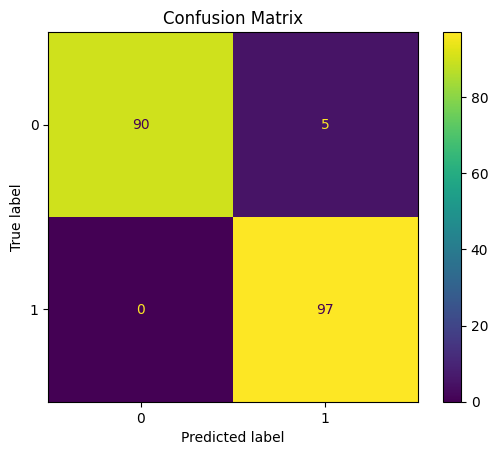

In [29]:
y_pred_probas = xgb_model.predict(data_test_matrix)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_probas]
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy = {round(accuracy, 3)}")
cm = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix")
ConfusionMatrixDisplay(cm).plot(ax=plt.gca())
task.close()

# Deep Learning with Tensorboard and Pytorch

In [ ]:
task = Task.init(project_name="Getting Started", task_name="TB Logging")

In [10]:
Task.get_task('cdf58eaa9d1e445182f5a38ad730a289').delete()

2023-05-24 17:00:09,921 - clearml.Task - WARNING - Task cdf58eaa9d1e445182f5a38ad730a289 was reset! if state is consistent we shall terminate.
2023-05-24 17:00:12,449 - clearml.Task - WARNING - Task cdf58eaa9d1e445182f5a38ad730a289 was reset! if state is consistent we shall terminate.


In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data.values)
        self.labels = torch.FloatTensor(labels.values)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)

# Set the hyperparameters
input_size = 9  # Number of input features
hidden_size = 16  # Number of units in the hidden layer
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Separate the features and labels
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_val = val_df.iloc[:, :-1]
y_val = val_df.iloc[:, -1]

# Instantiate the datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Define the neural network architecture
class BinaryClassificationNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.5):
        super(BinaryClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
model = BinaryClassificationNN(input_size, hidden_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Perform the training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Compute the training accuracy
    model.eval()
    with torch.no_grad():
        train_predictions = model(torch.FloatTensor(X_train))
        train_predictions = train_predictions.round().squeeze()
        train_accuracy = (train_predictions == y_train).sum().item() / len(y_train)

        val_loss = 0.0
        val_correct = 0
        val_total = 0
        for inputs, labels in val_dataloader:
            val_outputs = model(inputs)
            val_loss += criterion(val_outputs.squeeze(), labels).item()

            val_predictions = val_outputs.round().squeeze()
            val_correct += (val_predictions == labels).sum().item()
            val_total += len(labels)

    # Compute the validation accuracy
    val_accuracy
